In [14]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('mplstyle')
import numpy as np
import re
import graphviz
import pathlib

In [15]:
data_dir = '../../data/WebEx_Data'
cross_validations = 5
tested_vcas = ['webex']

# Utility Functions

In [16]:
def load_model_trial(path):
    with open(path, 'rb') as fd:
        model_trial = pickle.load(fd)
    return model_trial

def fps_prediction_accuracy(pred, truth):
    if len(pred) != len(truth):
        raise ValueError('Length mismatch for predictions and ground truth!')
    n = len(pred)
    df = pd.DataFrame({'pred': pred.to_numpy(), 'truth': truth.to_numpy()})
    df['deviation'] = df['pred']-df['truth']
    df['deviation'] = df['deviation'].abs()
    return df['deviation'].apply(lambda x: int(x <= 2))

# Lookup tables

In [17]:
model_name_lookup = {
        'IP/UDP-ML': 'framesPerSecond_ml_random_LSTATS-TSTATS_rf_regressor_full_video_WebEx_Data_cv_{}_original',
        'IP/UDP-non-ML': 'framesPerSecond_frame-lookback_random_none_none_full_video_WebEx_Data_cv_{}_original',
        'RTP-ML': 'framesPerSecond_rtp_ml_random_LSTATS-TSTATS_rf_regressor_full_video_WebEx_Data_cv_{}_original',
        'RTP-non-ML': 'framesPerSecond_rtp_random_LSTATS-TSTATS_rf_regressor_full_video_WebEx_Data_cv_{}_original'
}

col_map = {
        'framesPerSecond_pred': 'Frames Per Second Prediction',
        'framesPerSecond_webrtc': 'Ground Truth Frames Per Second',
        'throughput_mean_kbps': 'Throughput Mean (Kbps)',
        'throughput_std_kbps': 'Throughput Jitter (Kbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error (# frames)'
}

In [23]:
class FeatureImportanceVisualizer:
    def __init__(self, model_identifier):
        self.model_identifier = model_identifier
        
    def acquire_data(self):
        merged_data = {'Feature Importance': [], 'VCA': [], 'Feature': [], 'Cross Validation': []}
        for cv in range(1, cross_validations+1):
            folder_name = model_name_lookup[self.model_identifier].format(cv)
            model_trial_path = f'{data_dir}_intermediates/{folder_name}/{folder_name}.pkl'
            model_trial = load_model_trial(model_trial_path)
            with open(f'{data_dir}_intermediates/{model_trial.trial_id}/{model_trial.trial_id}_vca_model.pkl', 'rb') as fd:
                vca_model = pickle.load(fd)
                for vca in vca_model:
                    f_imp = vca_model[vca].feature_importances
                    for feature in f_imp:
                        if f_imp[feature] == 0:
                            continue
                        merged_data['Feature Importance'].append(f_imp[feature])
                        merged_data['Feature'].append(feature)
                        merged_data['VCA'].append(vca)
                        merged_data['Cross Validation'].append(cv)
        return pd.DataFrame(merged_data)

    def visualize(self):
        df_merged = self.acquire_data()
        n_cols = len(df_merged['VCA'].unique())
        fig, ax = plt.subplots(1, n_cols, figsize=(20, 18))
        idx = 0
        for vca in df_merged['VCA'].unique():
            if n_cols <= 1:
                axis = ax
            else:
                axis = ax[idx]
            axis.set_title(f'VCA = {vca}')
            axis.set_xlim([0, 1])
            axis.grid(visible=1)
            g = sns.barplot(data=df_merged[df_merged['VCA'] == vca], y = 'Feature', x = 'Feature Importance', hue = 'Cross Validation', ax=axis, errorbar=None, orient='h')
            for i in g.containers:
                g.bar_label(i,fmt='%.2f')
            idx += 1
        plt.suptitle(f'Model = {self.model_identifier}')
        plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

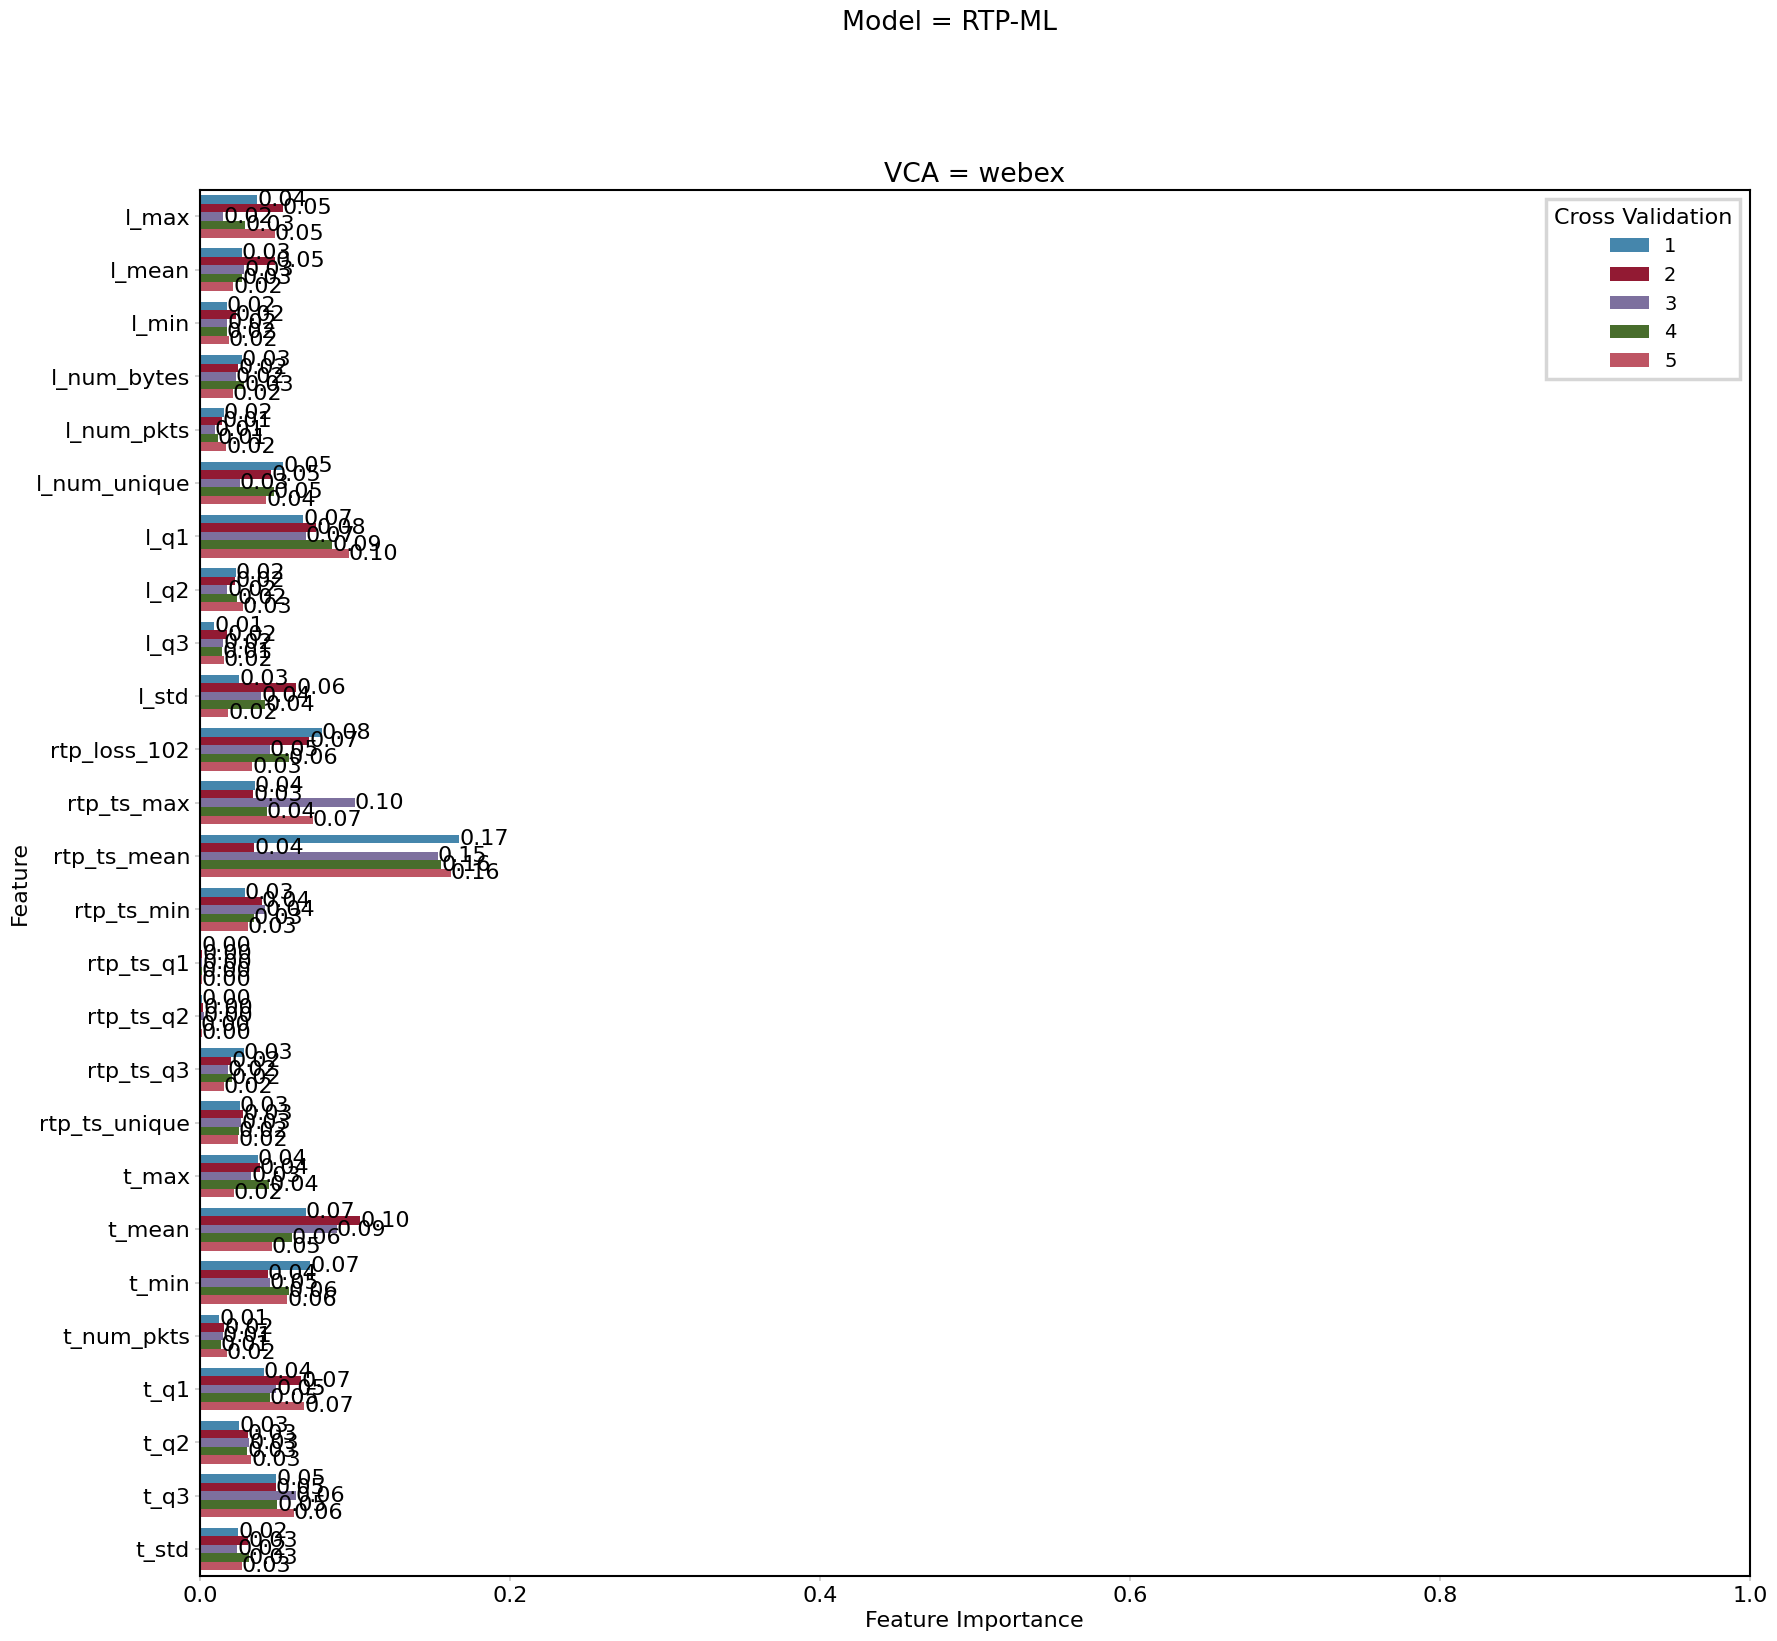

In [25]:
FeatureImportanceVisualizer('RTP-ML').visualize()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

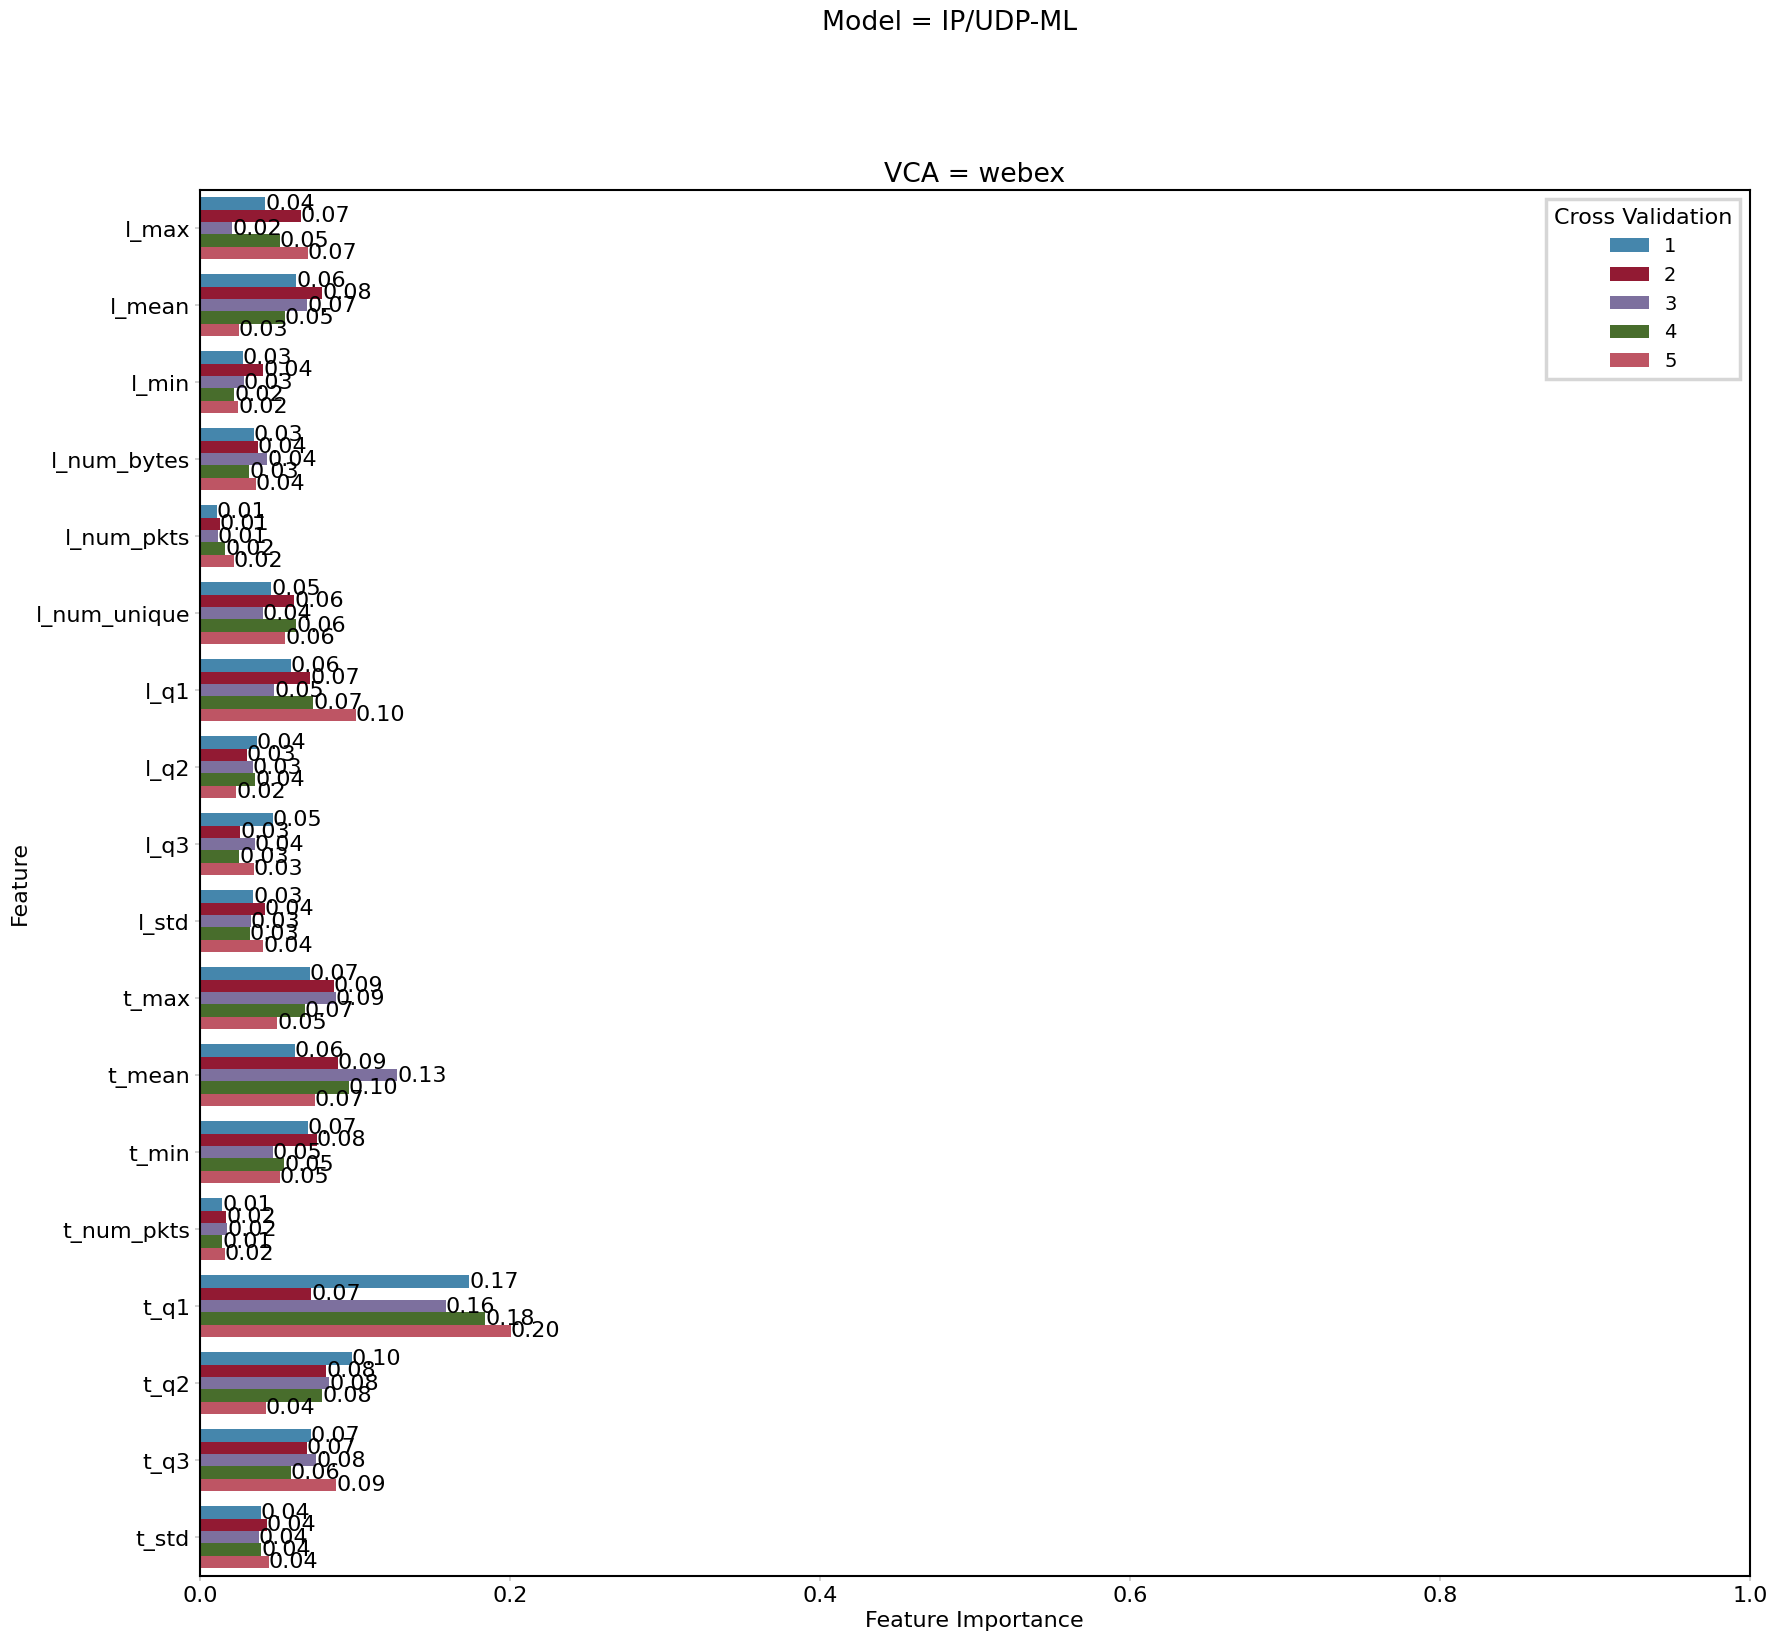

In [20]:
FeatureImportanceVisualizer('IP/UDP-ML').visualize()

# Analysis over network conditions

In [9]:
class NetworkConditionVisualizer:
    
    def __init__(self, model_identifiers):
        self.model_identifiers = model_identifiers
    
    def acquire_data(self):
        data = []
        for cv in range(1, cross_validations+1):
            for model_identifier in self.model_identifiers:
                folder_name = model_name_lookup[model_identifier].format(cv)
                model_trial_path = f'{data_dir}_intermediates/{folder_name}/{folder_name}.pkl'
                model_trial = load_model_trial(model_trial_path)
                with open(f'{data_dir}_intermediates/{model_trial.trial_id}/{model_trial.trial_id}_predictions.pkl', 'rb') as fd:
                    preds = pickle.load(fd)
                pred_merged = pd.concat(preds['webex'], axis=0)
                pred_merged = pred_merged.rename(columns = {f'{model_trial.metric}_{model_trial.estimation_method}': 'framesPerSecond_pred'})
                pred_merged['Deviation'] = pred_merged['framesPerSecond_pred'] - pred_merged[f'{model_trial.metric}_webrtc']
                pred_merged['MAE'] = pred_merged['Deviation'].apply(abs)
                pred_merged['Accuracy'] = 100*fps_prediction_accuracy(pred_merged['framesPerSecond_pred'], pred_merged[f'{model_trial.metric}_webrtc'])
                trace_files = []
                for f in pred_merged['file'].unique():
                    trace_num = f[:-5].split('-')[-3]
                    trace_files.append([x for x in os.listdir(f'{data_dir}_traces') if x.endswith('_'+trace_num+'.csv')][0])
                qos_time = []
                for f in trace_files:
                    trace = pd.read_csv(f'{data_dir}_traces/{f}', names = ['throughput', 'latency', 'loss'], index_col=False)
                    trace = trace.reset_index()
                    trace['throughput_dev'] = trace['throughput'].diff()
                    trace['throughput_dev'].fillna(0, inplace=True)
                    trace['latency_dev'] = trace['latency'].diff()
                    trace['latency_dev'].fillna(0, inplace=True)
                    timestamps = pd.read_csv(f'{data_dir}_traces/{f}.txt', names = ['timestamp'], index_col=False)
                    timestamps = timestamps.reset_index()
                    qt = pd.concat([trace, timestamps], axis=1)
                    qos_time.append(qt)
                qos_merged = pd.concat(qos_time, axis=0, ignore_index=True)
                qos_profile = pd.merge(pred_merged, qos_merged, on='timestamp')
                qos_profile['Method'] = model_identifier
                qos_profile['Cross Validation'] = cv
                data.append(qos_profile)
        return pd.concat(data, axis=0, ignore_index=True)
    
    def visualize(self, x, y, bins, y_bounds=None):
        df = self.acquire_data()
        labels = [f'[{round(bins[i])}-{round(bins[i+1])})' for i in range(len(bins)-1)]
        plt.figure(figsize=(20, 8))
        df[col_map[x]] = pd.cut(x = df[x], bins = bins, labels = labels, include_lowest = True)
        sns.boxplot(x=col_map[x], y = y, data=df, hue='Method', whis=[10,90], showfliers=False)
        plt.xlabel(col_map[x])
        plt.ylabel(col_map[y])
        if y_bounds:
            plt.ylim(y_bounds)
        plt.grid(visible=1)
        plt.show()

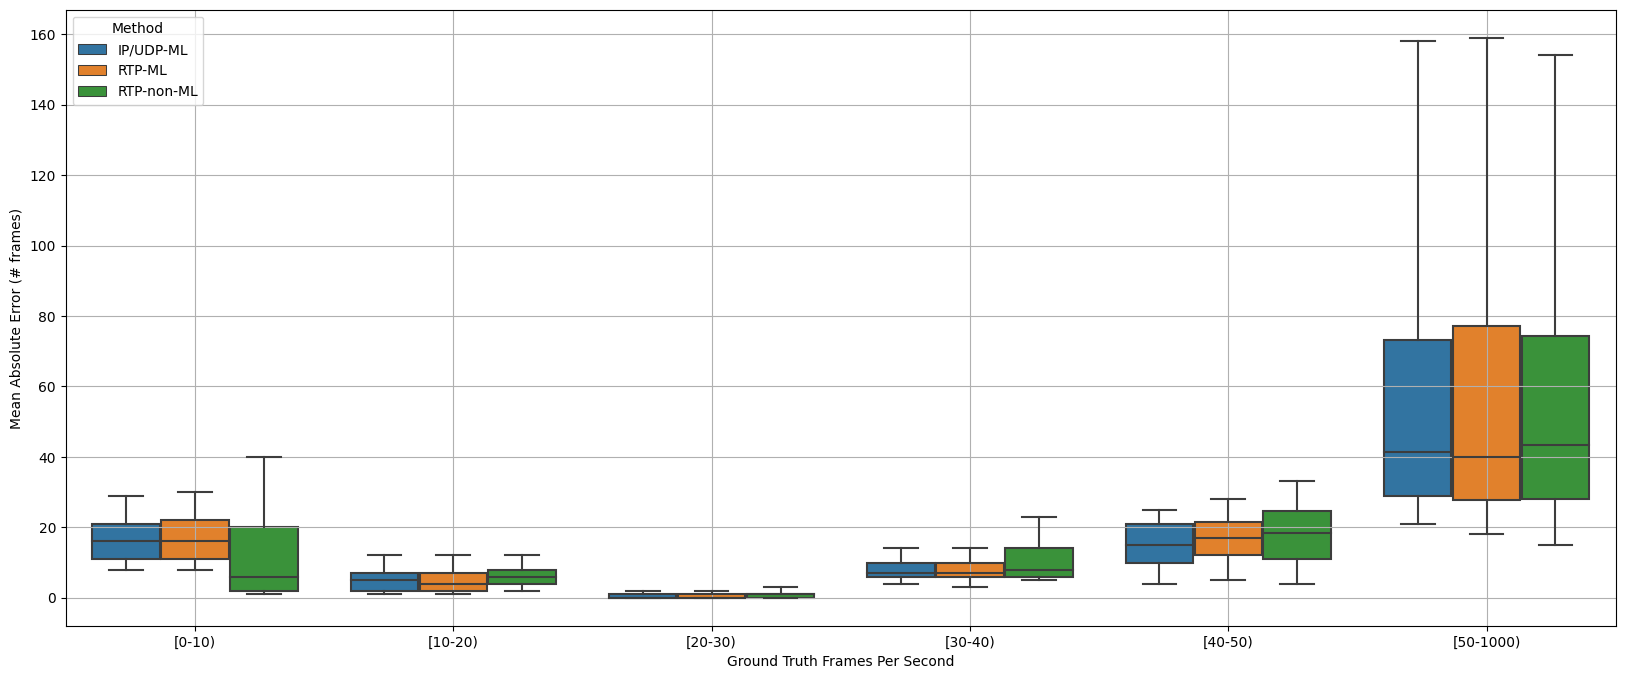

In [10]:
NetworkConditionVisualizer(['IP/UDP-ML', 'RTP-ML', 'RTP-non-ML']).visualize('framesPerSecond_webrtc', 'MAE', bins = list(range(0, 51, 10)) + [1000])

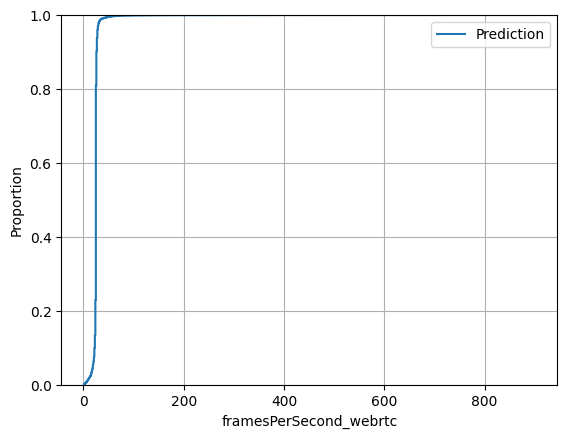

In [11]:
df = NetworkConditionVisualizer(['IP/UDP-ML', 'RTP-ML', 'RTP-non-ML']).acquire_data()
fig, ax = plt.subplots()

# sns.ecdfplot(x = 'framesPerSecond_pred', data = df[df['Method'] == 'IP/UDP-ML'], ax = ax)
sns.ecdfplot(x = 'framesPerSecond_webrtc', data = df[df['Method'] == 'IP/UDP-ML'], ax = ax)

plt.grid()
plt.legend(labels = ['Prediction', 'Ground Truth'])

Since the CDFs for the predictions and the ground truth almost overlap, it looks like the model is learning the right distribution. 

## Exploration of individual bins

### 1. Zooming in on the above plot

In [17]:
def diagnose_bin(lo, hi):
    df_sub = df[(df['framesPerSecond_webrtc'] >= lo) & (df['framesPerSecond_webrtc'] < hi) & (df['Method'] == 'IP/UDP-ML')]
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    # sns.ecdfplot(x = 'framesPerSecond_pred', data = df_sub, ax = ax[0])
    sns.ecdfplot(x = 'framesPerSecond_webrtc', data = df_sub, ax = ax[0])
    ax[0].set_title(f'Distribution of FPS over the interval [{lo}, {hi})')
    ax[0].set_xlabel('FPS')
    ax[0].grid()
    # ax[0].legend(labels = ['Prediction', 'Ground Truth'])
    
    df_sub['framesPerSecond_webrtc'].value_counts().plot.bar(ax = ax[1])
    count_bw_sub = len(df_sub)
    total = len(df[df['Method'] == 'IP/UDP-ML'])
    perc = round(100*count_bw_sub / total, 2)
    ax[1].grid()
    ax[1].set_title(f'Value counts for different FPS values\nNumber of samples = {perc}% of {total}')
    plt.show()
    net_vars = ['throughput', 'latency', 'loss']
    fig, axes = plt.subplots(1, len(net_vars), figsize=(20, 5))

    df_sub['Nature of predictions'] = df_sub['MAE'].apply(lambda x: 'MAE > 2' if x > 2 else 'MAE <= 2')
    
    for i in range(len(net_vars)):
        sns.ecdfplot(data = df_sub, x = net_vars[i], ax=axes[i], hue='Nature of predictions')
        axes[i].grid()
    plt.suptitle('Distribution of network metrics and nature of predictions')
    plt.show()
    
    plt.figure(figsize = (20, 5))
    sns.scatterplot(data = df_sub, x = 'throughput', y = 'latency', hue = 'Nature of predictions')
    plt.grid()
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    sns.scatterplot(data = df_sub, x = 'throughput', y = 'MAE', hue = 'loss', ax = axes[0])
    axes[0].set_ylim([-1, 20])
    axes[0].grid()
    sns.scatterplot(data = df_sub, x = 'latency', y = 'MAE', hue = 'loss', ax = axes[1])
    axes[1].set_ylim([-1, 20])
    axes[1].grid()
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    sns.scatterplot(data = df_sub, x = 'throughput_dev', y = 'MAE', hue = 'loss', ax = axes[0])
    axes[0].set_ylim([-20, 20])
    axes[0].grid()
    sns.scatterplot(data = df_sub, x = 'latency_dev', y = 'MAE', hue = 'loss', ax = axes[1])
    axes[1].set_ylim([-20, 20])
    axes[1].grid()
    plt.show()

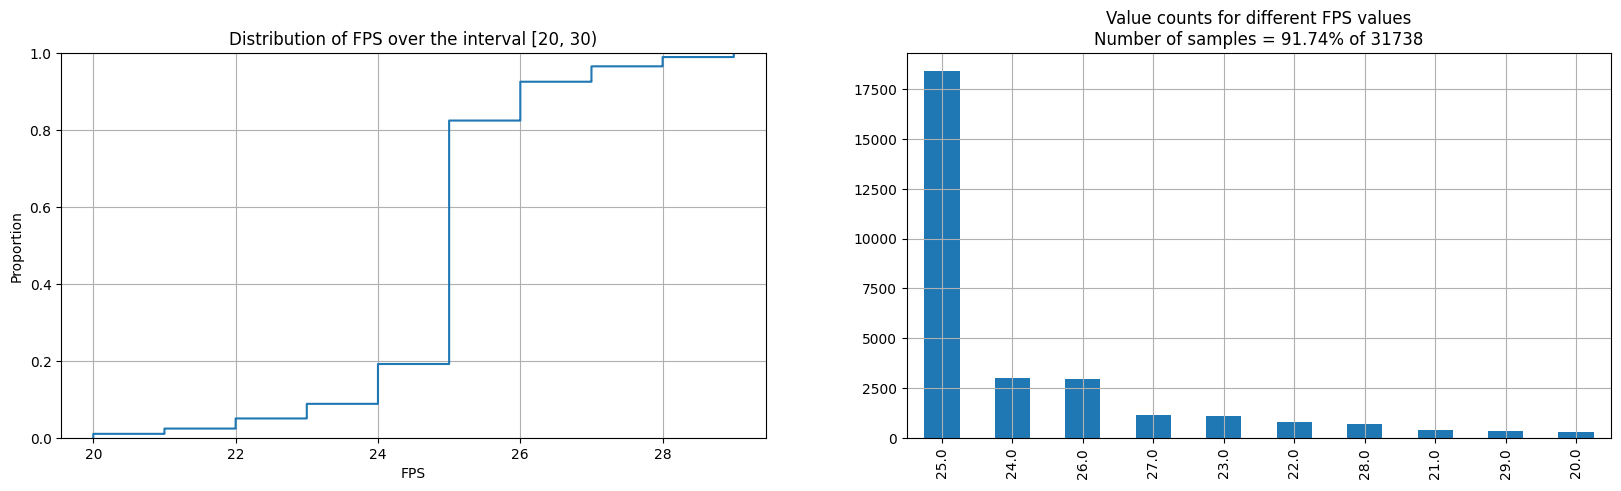

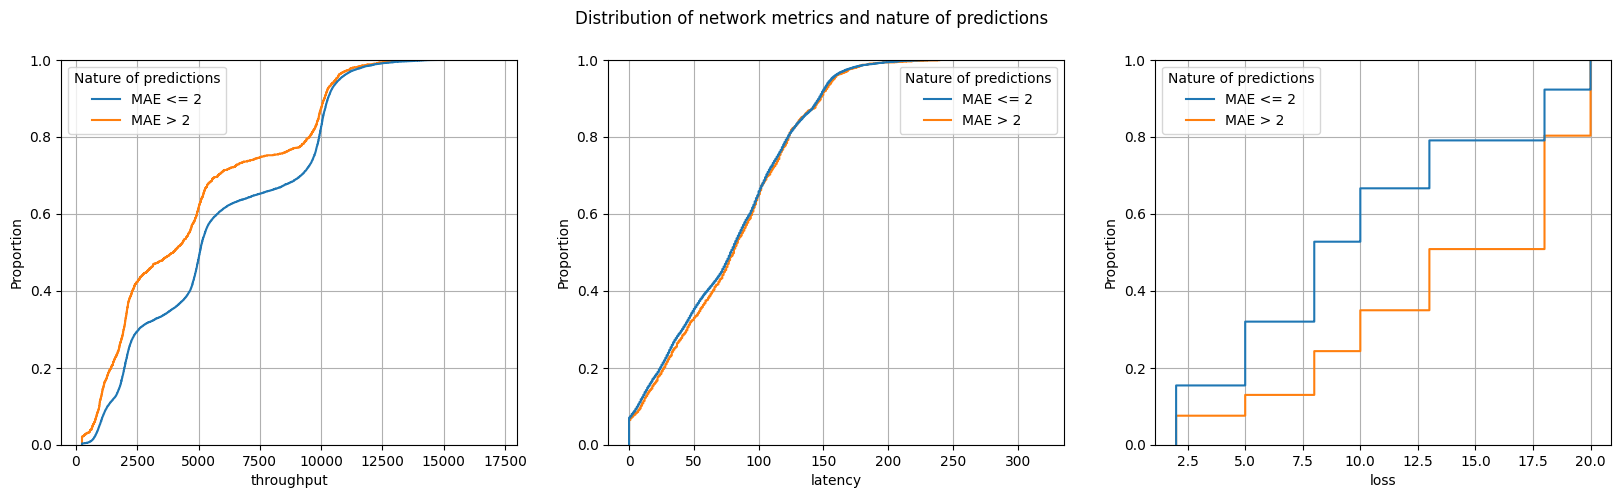

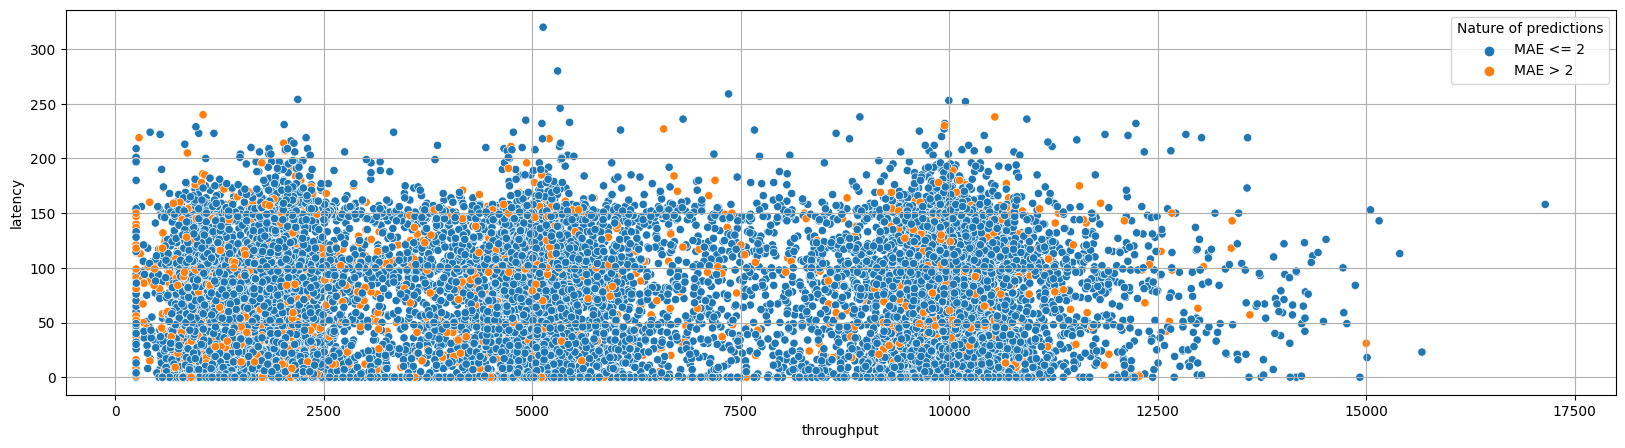

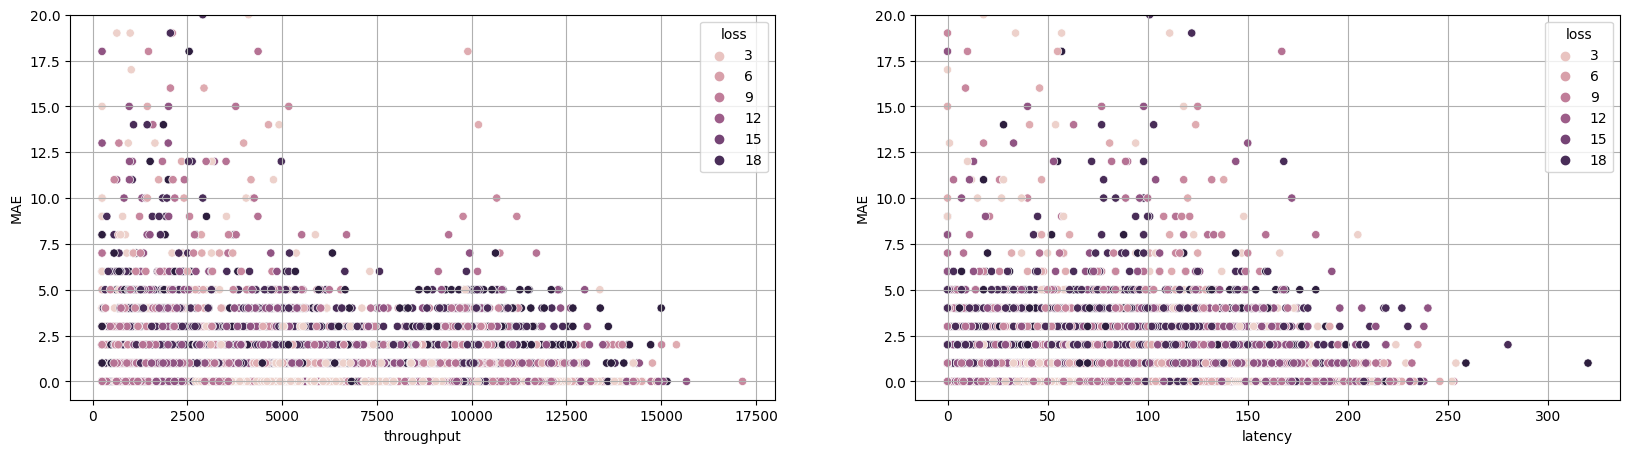

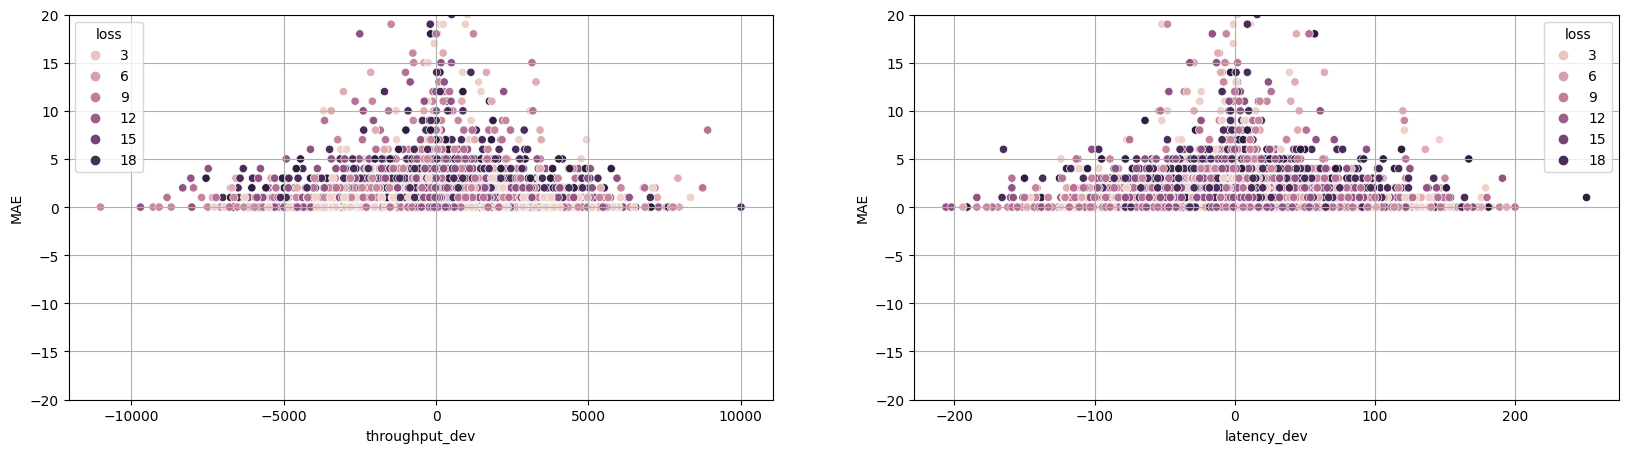

In [19]:
diagnose_bin(20, 30)